# ***Import Necessary Libraries***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy import stats

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier\

from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline



# ***Dataset Information***

In [2]:
df = pd.read_csv('engine_data.csv')


##### ***Display dataset head and tail***

In [3]:
df.head()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
1         876          2.941606      16.193866          2.464504   
2         520          2.961746       6.553147          1.064347   
3         473          3.707835      19.510172          3.727455   
4         619          5.672919      15.738871          2.052251   

   lub oil temp  Coolant temp  Engine Condition  
0     84.144163     81.632187                 1  
1     77.640934     82.445724                 0  
2     77.752266     79.645777                 1  
3     74.129907     71.774629                 1  
4     78.396989     87.000225                 0

In [4]:
df.tail()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
19530         902          4.117296       4.981360          4.346564   
19531         694          4.817720      10.866701          6.186689   
19532         684          2.673344       4.927376          1.903572   
19533         696          3.094163       8.291816          1.221729   
19534         504          3.775246       3.962480          2.038647   

       lub oil temp  Coolant temp  Engine Condition  
19530     75.951627     87.925087                 1  
19531     75.281430     74.928459                 1  
19532     76.844940     86.337345                 1  
19533     77.179693     73.624396                 1  
19534     75.564313     80.421421                 1

##### ***Display dataset information***

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


#### ***Visualize Dataset features***

In [6]:
def visualize_dataset_features(df= df):
    plt.figure(figsize=(12, 8))
    df.hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
    plt.suptitle("Feature Distributions", fontsize=16)
    plt.tight_layout()
    plt.show()

    sns.pairplot(df, hue="Engine Condition", diag_kind="kde",
                palette={0: "salmon", 1: "skyblue"}, corner=True)
    plt.suptitle("Pairwise Feature Relationships", y=1.02)
    plt.show()

def visualize_class_distribution(Y):
    counts = Y.value_counts()
    ax = counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title("Engine Health Class Distribution")
    plt.xlabel("Engine Health")
    plt.ylabel("Count")
    for i, count in enumerate(counts):
        plt.text(i, count + (0.01 * max(counts)), str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.show()



<Figure size 1200x800 with 0 Axes>

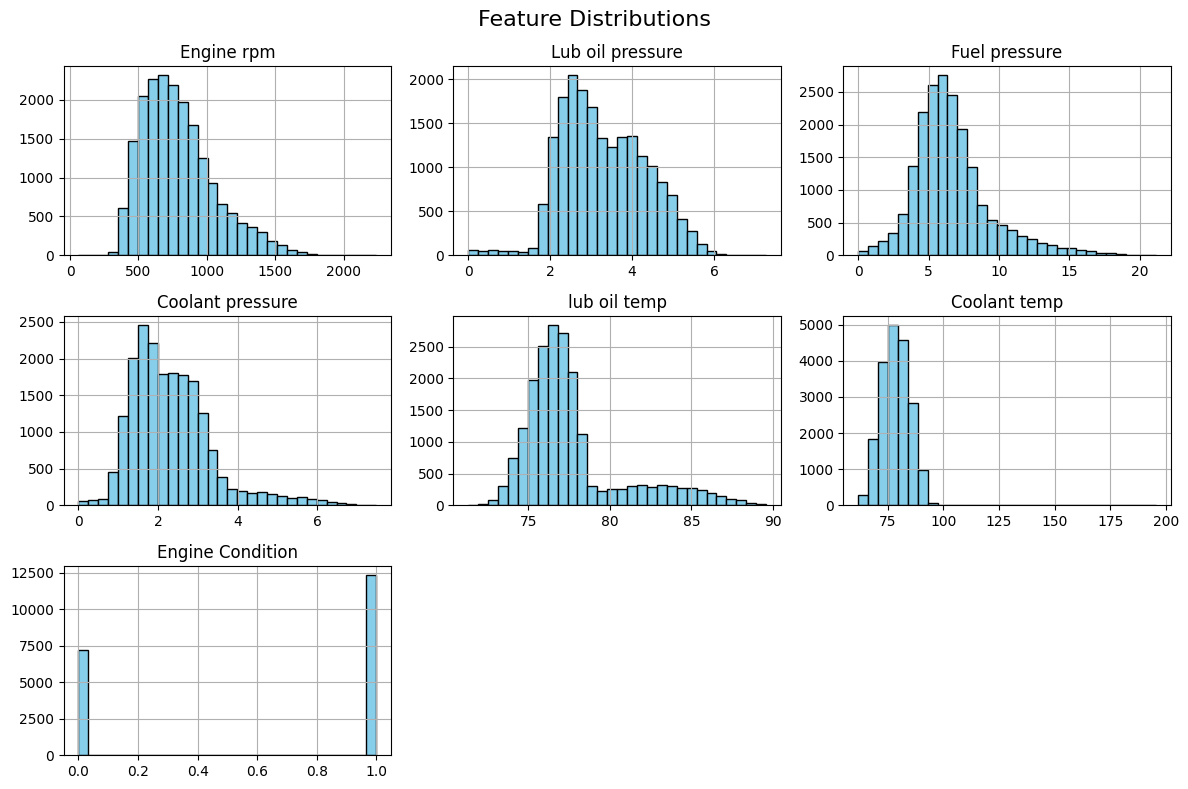

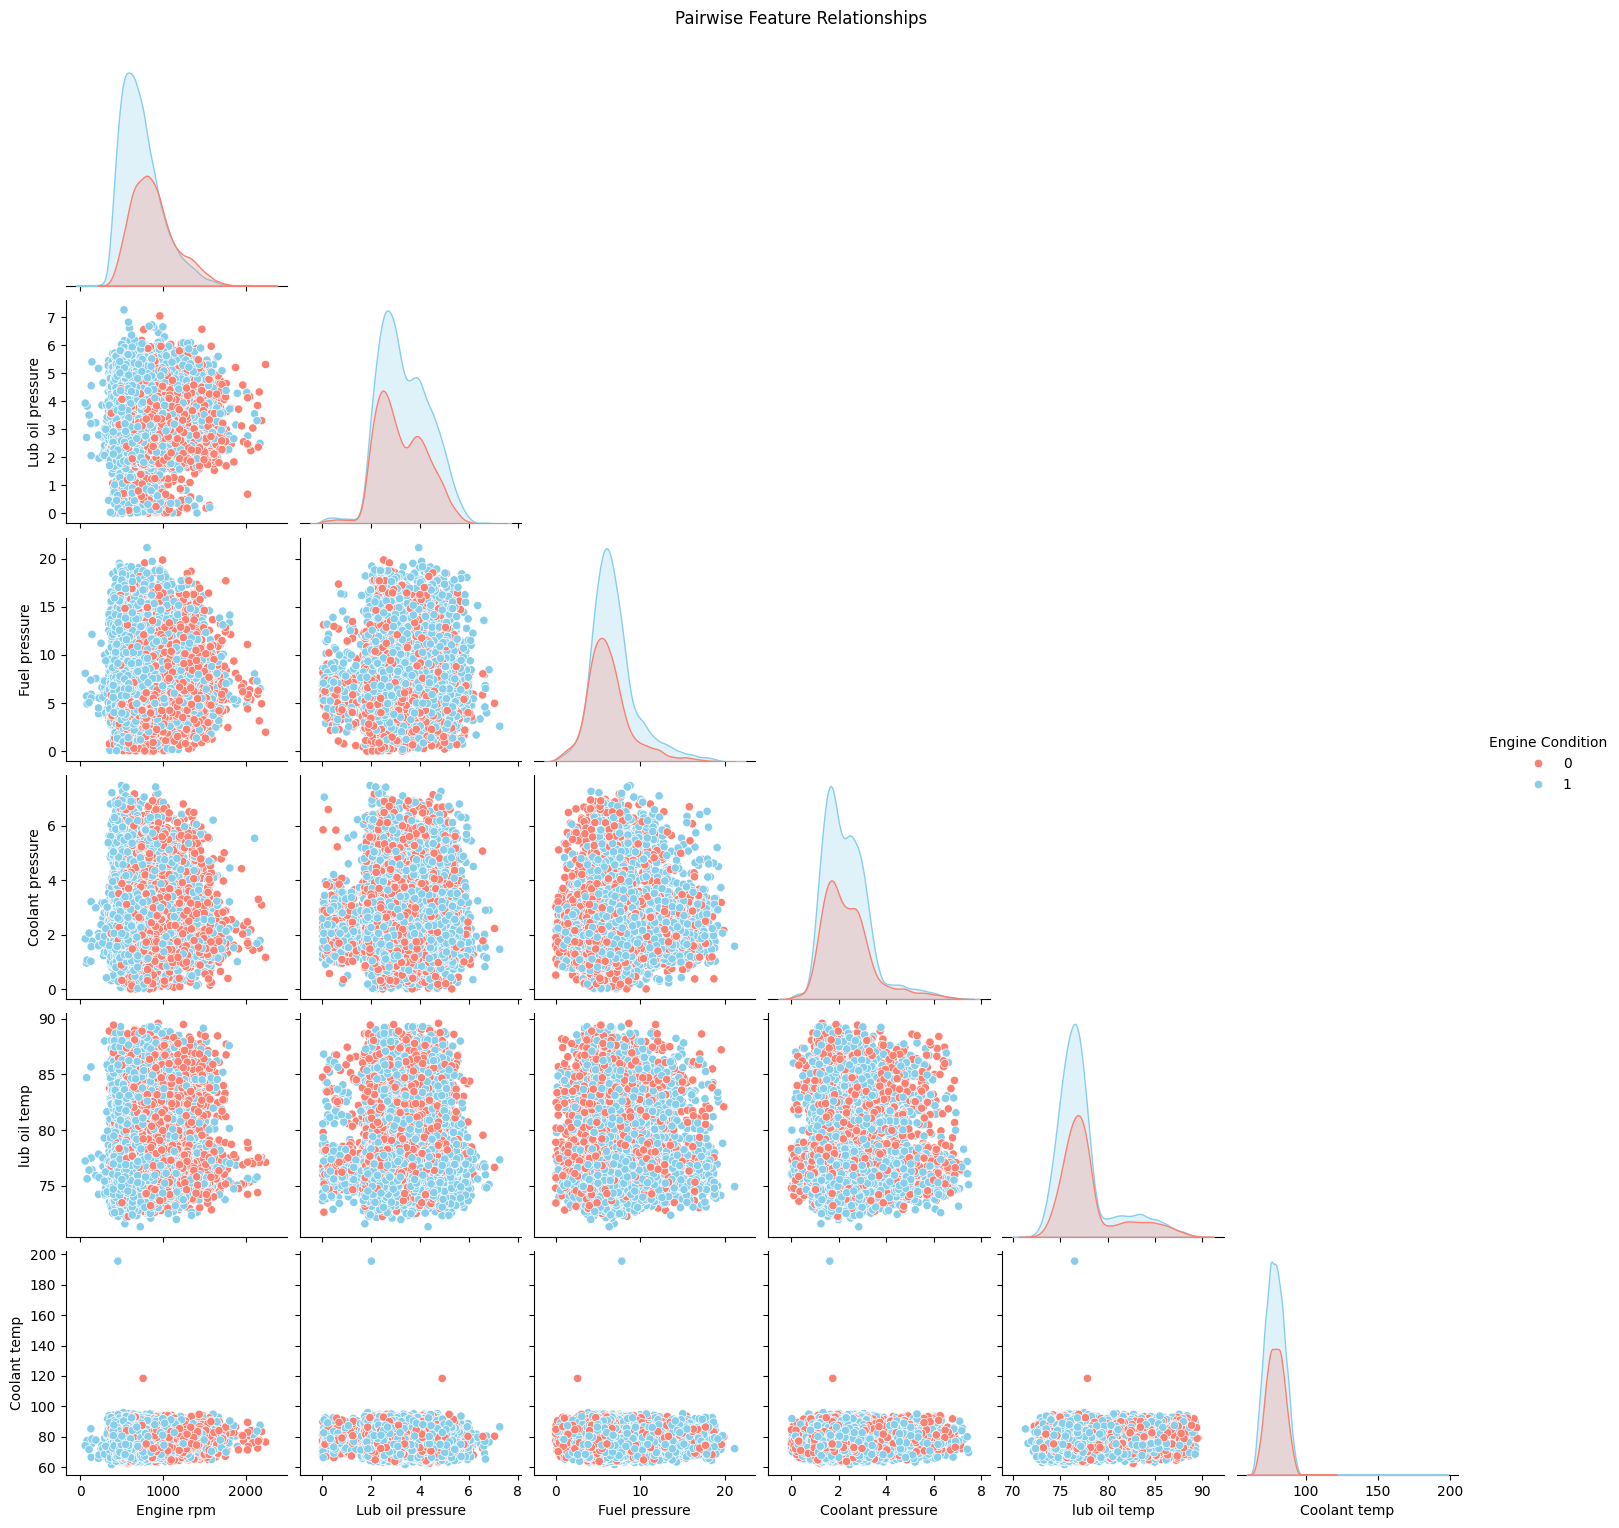

In [7]:
visualize_dataset_features()

**Insights**: *there are some outliers that might affect our model, so will remove that later on*

#### ***Check null values***

Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
Engine Condition    0
dtype: int64


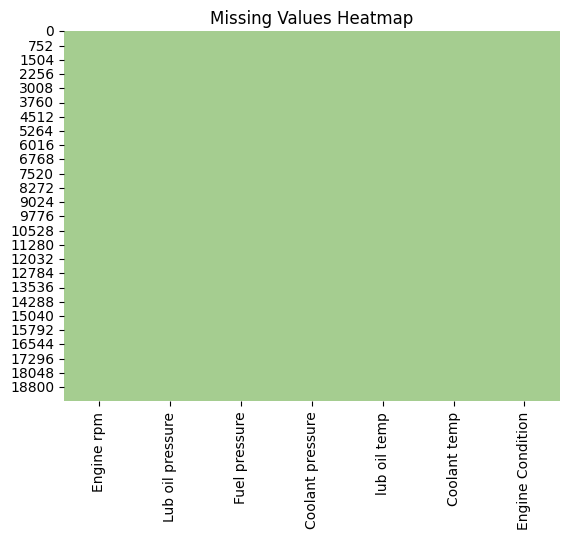

In [8]:
print(df.isnull().sum())

sns.heatmap(df.isnull(), cbar=False, cmap='crest')
plt.title("Missing Values Heatmap")
plt.show()

**Insights**: *The dataset is already cleaned and there's no null values can be seen.*

#### ***Check duplicate rows***

Duplicate rows: 0


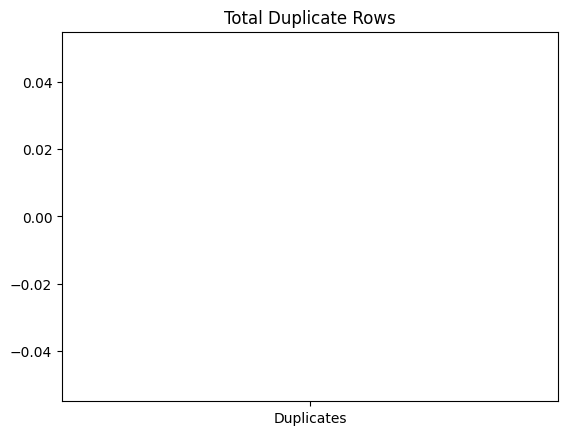

In [9]:
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

duplicate_count = df.duplicated().sum()
plt.bar(['Duplicates'], [duplicate_count])
plt.title("Total Duplicate Rows")
plt.show()

**Insights:** *There's no duplicate values on the given dataset*

#### ***Check target columns' class ratio***

Engine Condition
1    12317
0     7218
Name: count, dtype: int64


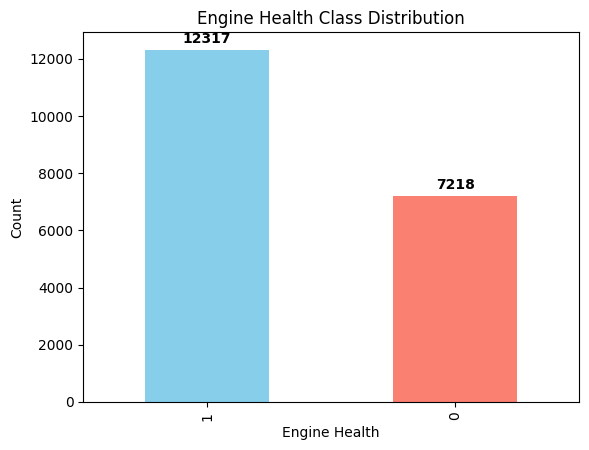

In [10]:
print(df["Engine Condition"].value_counts())

visualize_class_distribution(df["Engine Condition"])

**Insights**: *The problem here is that the target values are not even to each other*

# ***Preprocessing Data***

### ***Feature Engineering***


In [11]:
epsilon = 1e-6

# Create new features
df["oil_to_coolant_temp_ratio"] = df["lub oil temp"] / (df["Coolant temp"] + epsilon)
df["temp_difference"] = df["lub oil temp"] - df["Coolant temp"]
df["oil_to_fuel_pressure_ratio"] = df["Lub oil pressure"] / (df["Fuel pressure"] + epsilon)
df["pressure_difference"] = df["Lub oil pressure"] - df["Coolant pressure"]
df["engine_stress_index"] = (df["Engine rpm"] * df["Fuel pressure"]) / df["Lub oil pressure"]

**Note**: *We added these features to further boost our data quality*

#### ***Check new features***

In [12]:
df.head()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
1         876          2.941606      16.193866          2.464504   
2         520          2.961746       6.553147          1.064347   
3         473          3.707835      19.510172          3.727455   
4         619          5.672919      15.738871          2.052251   

   lub oil temp  Coolant temp  Engine Condition  oil_to_coolant_temp_ratio  \
0     84.144163     81.632187                 1                   1.030772   
1     77.640934     82.445724                 0                   0.941722   
2     77.752266     79.645777                 1                   0.976226   
3     74.129907     71.774629                 1                   1.032815   
4     78.396989     87.000225                 0                   0.901112   

   temp_difference  oil_to_fuel_pressure_ratio  pressure_difference  \
0         2.511976                    0.211484            -0.685389   
1        -4.804790                    0.181649             0.477102   
2        -1.893511                    0.451958             1.897399   
3         2.355278                    0.190046            -0.019621   
4        -8.603237                    0.360440             3.620667   

   engine_stress_index  
0          3309.943952  
1          4822.476755  
2          1150.550006  
3          2488.867988  
4          1717.345535

#### ***Removing outliers***

<Figure size 1200x800 with 0 Axes>

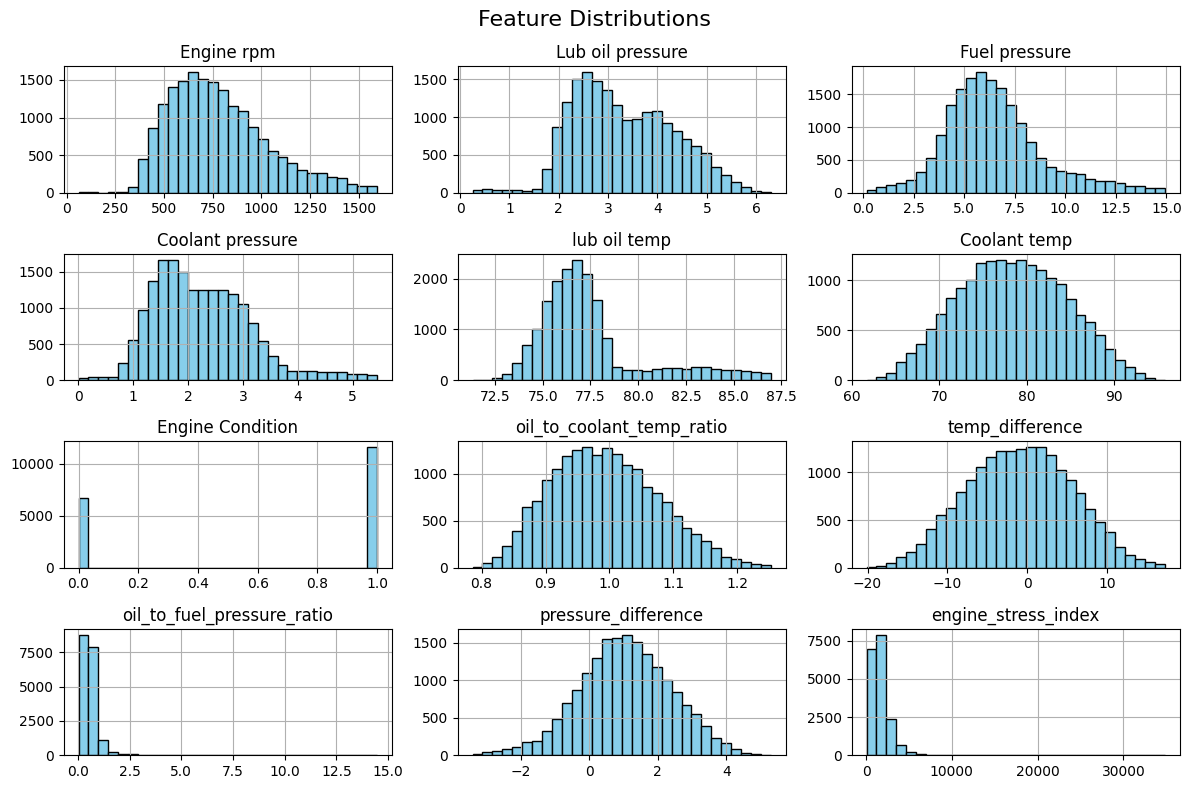

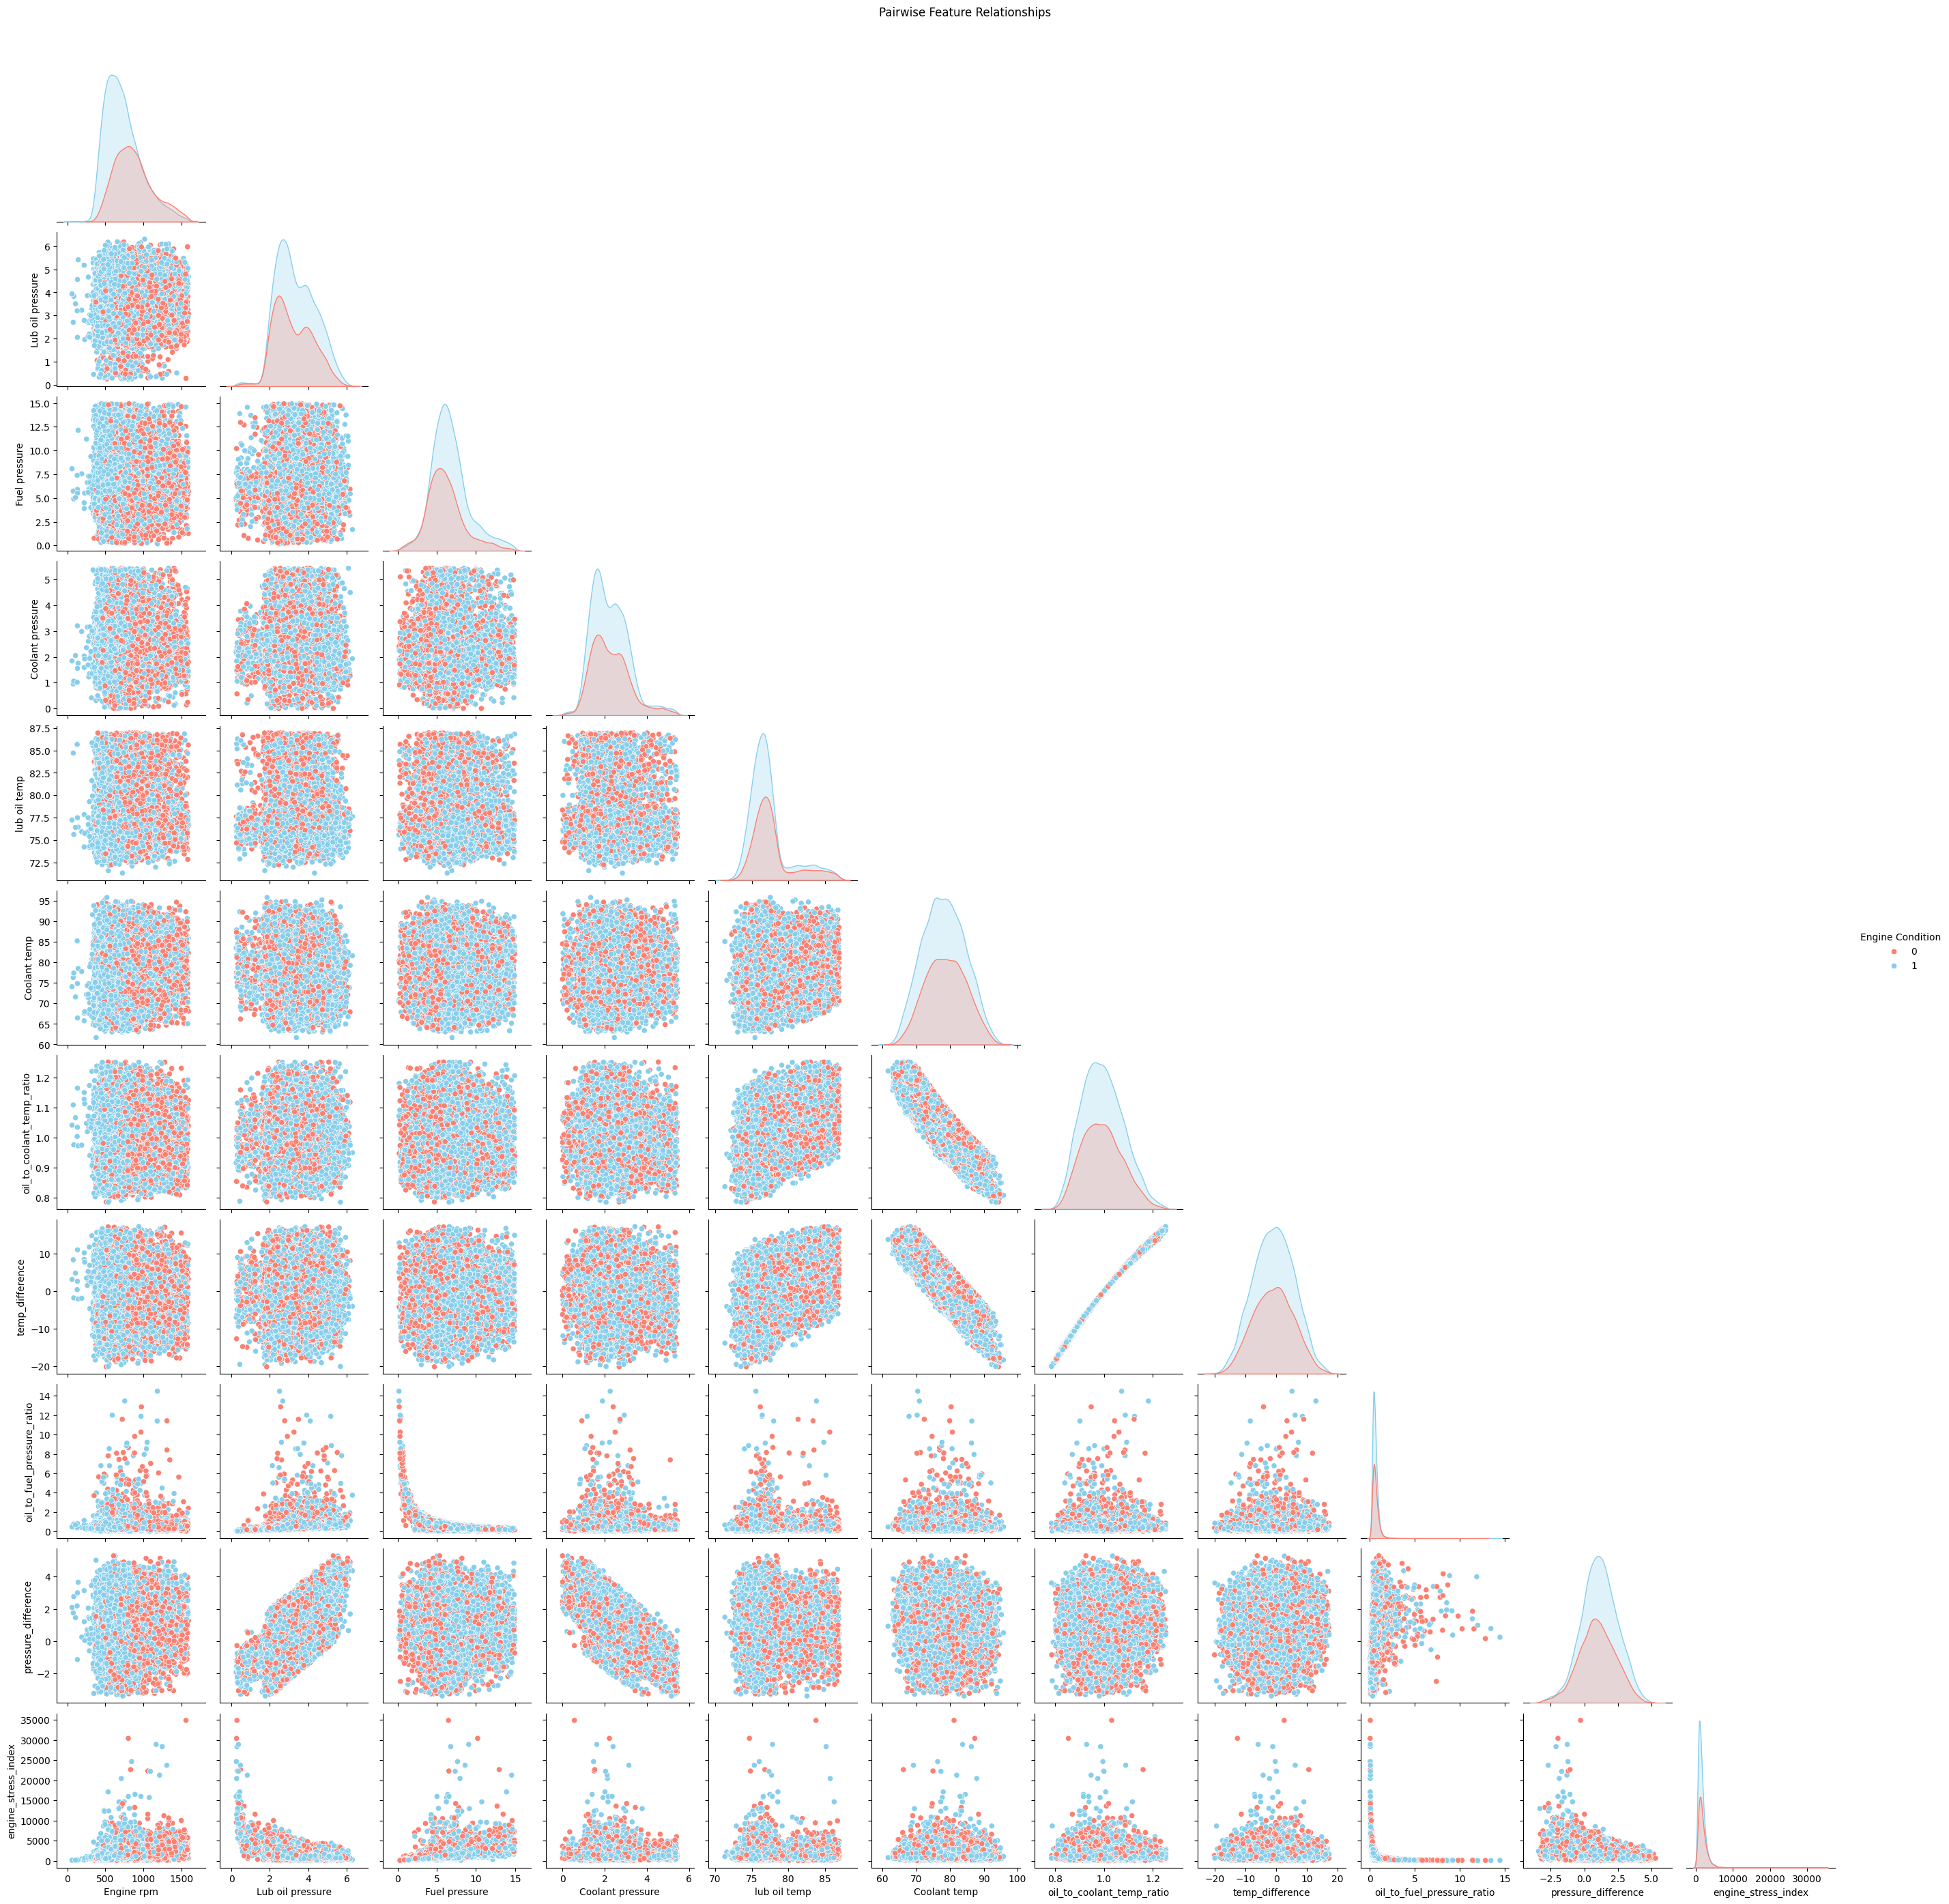

In [13]:
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

visualize_dataset_features(df)



**Note**: *We removed the outliers so we can eliminate noises that can diminish our model performance*

#### ***Recheck features correlations***

Engine Condition              1.000000
Fuel pressure                 0.119469
Lub oil pressure              0.061440
pressure_difference           0.056768
oil_to_coolant_temp_ratio     0.005744
temp_difference               0.003155
Coolant pressure             -0.016633
Coolant temp                 -0.045104
oil_to_fuel_pressure_ratio   -0.056492
engine_stress_index          -0.081996
lub oil temp                 -0.089113
Engine rpm                   -0.267087
Name: Engine Condition, dtype: float64


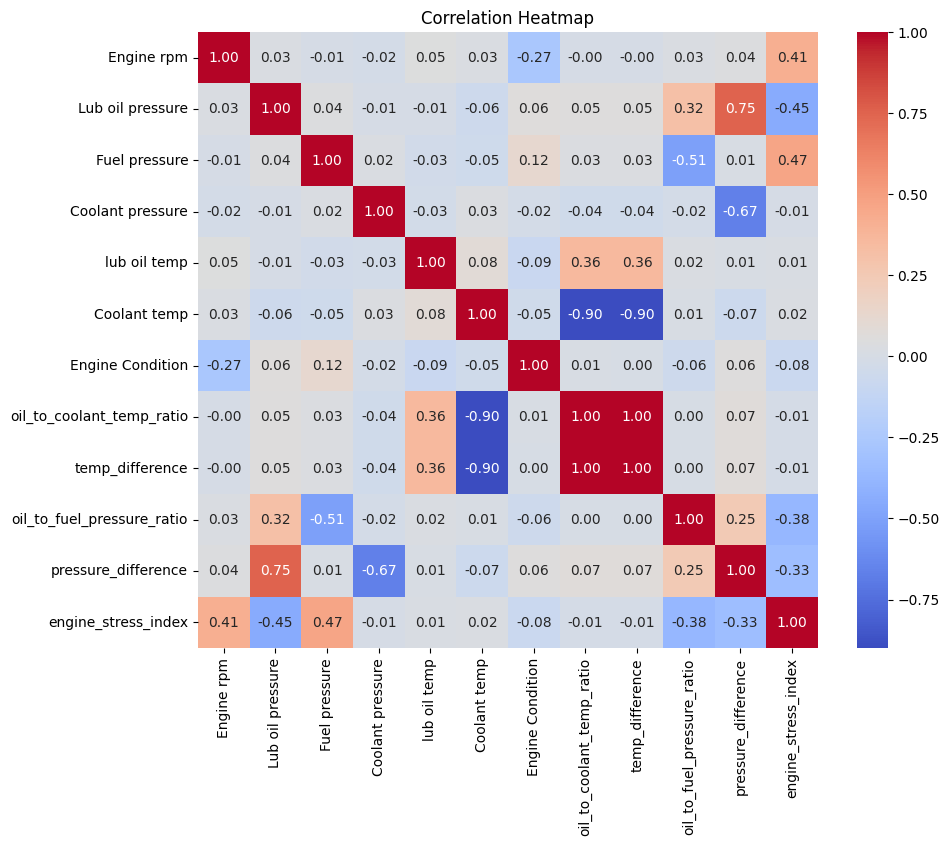

In [14]:
print(df.corr(numeric_only=True)["Engine Condition"].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Insights**: *Based on the given visualisation of the correlation of all features, we find out that engineered features shows that relationship exists but they are *Non-Linear**

*it means engine health isn’t linearly dependent on a single sensor reading, but rather on combinations (interactions and thresholds).*

*The new features will become more valuable in non-linear models like Random Forest because those capture complex dependencies that correlations cannot.*

### ***Resampling Dataset***

/tmp/ipykernel_71881/1336451823.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt["Engine Condition"] = y_resampled


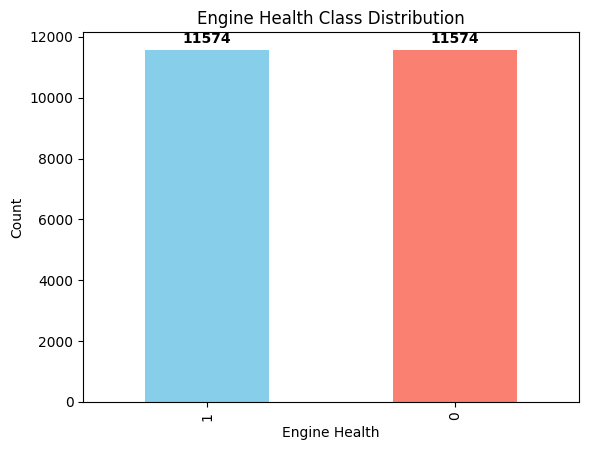

In [15]:

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df.drop('Engine Condition', axis=1), df['Engine Condition'])

dt = df
dt["Engine Condition"] = y_resampled
visualize_class_distribution(y_resampled)

**Insights:** *Resampled the dataset to get even more accurate and unbiased data*

#### ***Preprocess Data***

In [16]:
X = X_resampled
y = y_resampled

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [17]:
df.head()

Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
0         700          2.493592      11.790927          3.178981   
2         520          2.961746       6.553147          1.064347   
5        1221          3.989226       6.679231          2.214250   
6         716          3.568896       5.312266          2.461067   
7         729          3.845166      10.191126          2.362998   

   lub oil temp  Coolant temp  Engine Condition  oil_to_coolant_temp_ratio  \
0     84.144163     81.632187                 1                   1.030772   
2     77.752266     79.645777                 0                   0.976226   
5     76.401152     75.669818                 0                   1.009665   
6     83.646589     79.792411                 0                   1.048303   
7     77.921202     71.671761                 0                   1.087195   

   temp_difference  oil_to_fuel_pressure_ratio  pressure_difference  \
0         2.511976                    0.211484            -0.685389   
2        -1.893511                    0.451958             1.897399   
5         0.731334                    0.597258             1.774976   
6         3.854178                    0.671822             1.107829   
7         6.249442                    0.377305             1.482167   

   engine_stress_index  
0          3309.943952  
2          1150.550006  
5          2044.341587  
6          1065.759006  
7          1932.122457

**Note**: *Use Label Encoder to ensure the class are in the same data_type, and StandardScaler for feature standardization*

# ***Training Model***

### ***Model selection and performance comparison***

#### ***Model Performance Helpers***

In [18]:
def show_model_accuracy(model_name, y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print detailed report
    print(f"{model_name} Accuracy: ", accuracy)
    print(classification_report(y_true, y_pred))

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Bar chart for metrics
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    plt.figure(figsize=(6, 4))
    plt.bar(metrics.keys(), metrics.values(), color=['steelblue'])
    plt.ylim(0, 1)
    plt.title(f"{model_name} Performance Metrics")
    plt.ylabel("Score")

    # Display metric values on top of bars
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

    plt.show()

    return accuracy

def cross_validation_setup(model, scoring="f1_macro"):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)

    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Score:", np.mean(cv_scores))

    # Visualization
    plt.figure(figsize=(6, 4))
    folds = [f"Fold {i+1}" for i in range(len(cv_scores))]
    plt.bar(folds, cv_scores, color='teal', alpha=0.7)
    plt.axhline(np.mean(cv_scores), color='red', linestyle='--', label=f"Mean ({np.mean(cv_scores):.3f})")
    plt.title(f"Cross-Validation {scoring.upper()} Scores")
    plt.ylabel("Score")
    plt.xlabel("Fold")
    plt.legend()
    plt.ylim(0, 1)

    # Add text labels above bars
    for i, score in enumerate(cv_scores):
        plt.text(i, score + 0.01, f"{score:.3f}", ha='center', fontweight='bold')

    plt.show()

    return cv_scores



#### ***Hypertune individual models***

In [19]:
def hypertune_and_evaluate(model_name, model, param_grid, X_train, X_test, y_train, y_test):
    print(f"Now tuning {model_name}...")
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Best Params for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Test Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("-" * 60)

    return best_model

param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["liblinear", "lbfgs"]
    },
    "KNN": {
        "n_neighbors": [11, 13, 15, 17, 21, 23],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    },
    "SVM": {
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", 0.1, 0.01, 0.001],
        "kernel": ["rbf"]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300, 400],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 4, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 5, 10, 20, 30],
        "min_samples_split": [2, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [200, 300],
        "max_depth": [5, 7],
        "learning_rate": [0.05, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1],
        "min_child_weight": [1, 3],
    },
    "Gradient Boosting":{
        'n_estimators': [50, 100, 150],       
        'learning_rate': [0.05, 0.1, 0.2],   
        'max_depth': [2, 3, 4],               
        'min_samples_split': [2, 4],          
        'min_samples_leaf': [1, 2],      
        'subsample': [0.8, 1.0]  
    }
}

# RUN ONLY ONCE

models = {
    # "Logistic Regression": LogisticRegression(max_iter=5000, random_state=42),
    # "KNN": KNeighborsClassifier(),
    # # "SVM": SVC(random_state=42),
    # "Random Forest": RandomForestClassifier(random_state=42),
    # "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "XGBoost": XGBClassifier(random_state=42)
    # "Gradient Boosting": GradientBoostingClassifier(random_state=42)   
}
best_models = {}

for name, model in models.items():
    best_models[name] = hypertune_and_evaluate(
        name, model, param_grids[name], X_train, X_test, y_train, y_test
    )


**Insights**: *Used GridSearchCV to determine what is the best configuration for given*

#### ***Logistic Regression Model***




Logistic Regression Accuracy:  0.6403887688984882
              precision    recall  f1-score   support

           0       0.60      0.64      0.62      2129
           1       0.68      0.64      0.66      2501

    accuracy                           0.64      4630
   macro avg       0.64      0.64      0.64      4630
weighted avg       0.64      0.64      0.64      4630



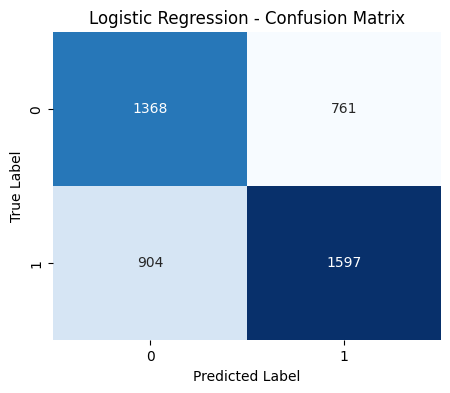

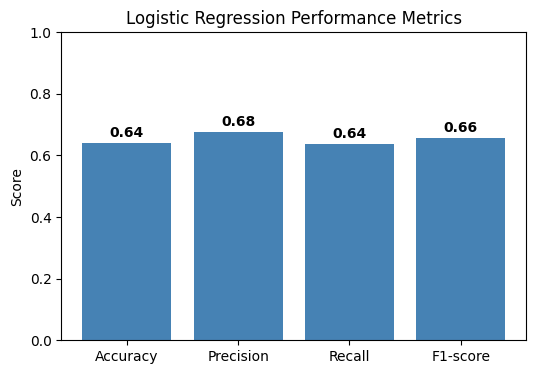

Cross-Validation Scores: [0.63537982 0.63606101 0.63663584 0.64106452 0.63940005]
Mean CV Score: 0.6377082481440685


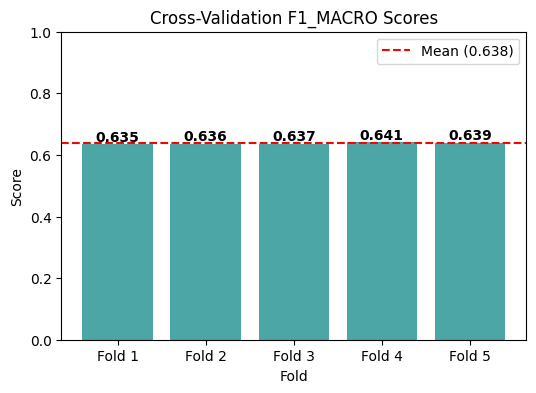

array([0.63537982, 0.63606101, 0.63663584, 0.64106452, 0.63940005])

In [20]:
log_reg = make_pipeline(StandardScaler(), LogisticRegression(
    max_iter=5000,
    random_state=42,
    C=1,
    solver='lbfgs'
))
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy_lr = show_model_accuracy("Logistic Regression", y_pred, y_test)

# --- Cross Validation Setup ---
cross_validation_setup(log_reg, )


**Insights**: *Based on the result, Logisitic Regression(LR) is not compatible with our dataset because LR is a linear model and based on coeffecient between features, our dataset is non-linear*

#### ***KNN model***

KNN Accuracy:  0.727645788336933
              precision    recall  f1-score   support

           0       0.87      0.67      0.76      2927
           1       0.59      0.82      0.69      1703

    accuracy                           0.73      4630
   macro avg       0.73      0.75      0.72      4630
weighted avg       0.77      0.73      0.73      4630



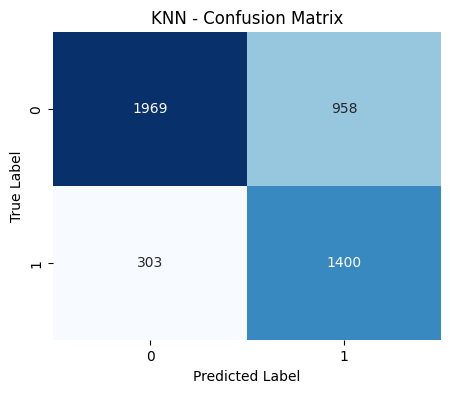

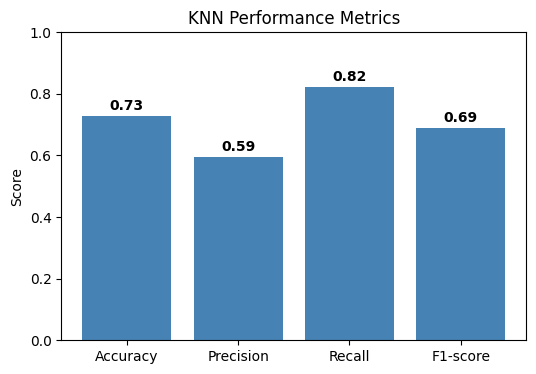

Cross-Validation Scores: [0.71913749 0.70827403 0.70793581 0.72383248 0.70836376]
Mean CV Score: 0.713508716073761


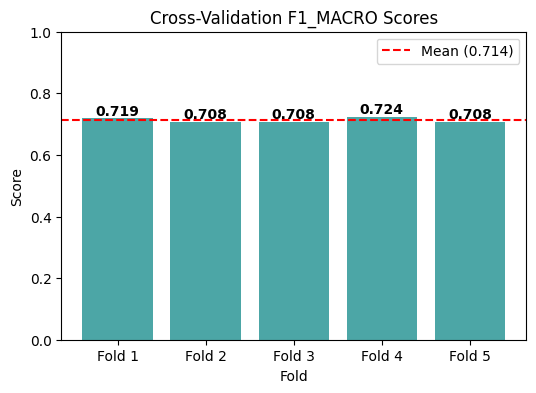

array([0.71913749, 0.70827403, 0.70793581, 0.72383248, 0.70836376])

In [21]:
knn = KNeighborsClassifier(
    n_neighbors=23,
    metric='euclidean',
    weights='distance'

)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_knn =show_model_accuracy("KNN", y_pred, y_test)

# --- Cross Validation Setup ---
cross_validation_setup(knn)


**Insights**: *KNN shows a promising result, we will include these on our stacked ensemble*

#### ***SVM Model***

SVM Accuracy:  0.6529157667386609
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      2487
           1       0.61      0.68      0.64      2143

    accuracy                           0.65      4630
   macro avg       0.65      0.65      0.65      4630
weighted avg       0.66      0.65      0.65      4630



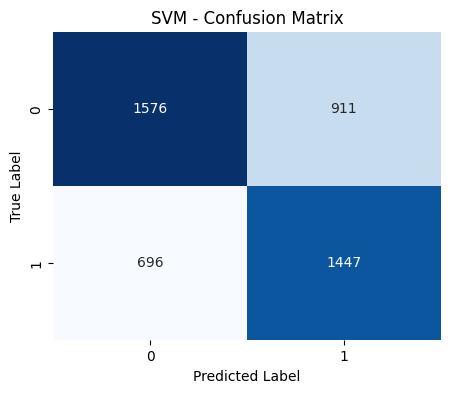

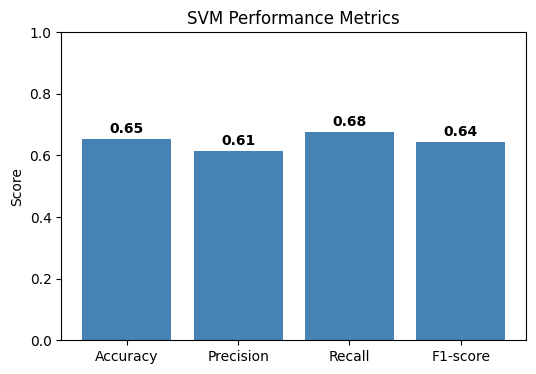

Cross-Validation Scores: [0.65575462 0.65907279 0.65061505 0.65876151 0.64973051]
Mean CV Score: 0.654786897003055


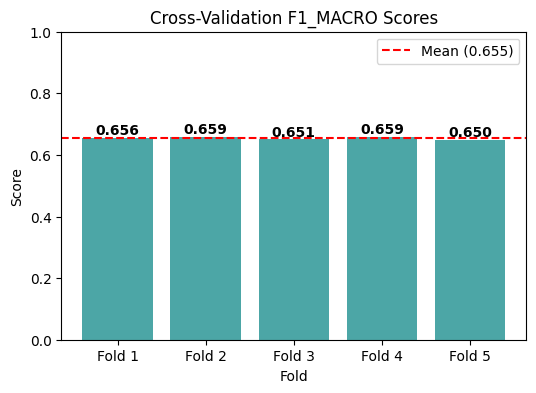

array([0.65575462, 0.65907279, 0.65061505, 0.65876151, 0.64973051])

In [22]:
svm = make_pipeline(StandardScaler(), SVC(
    kernel='rbf',
    random_state=42,
    C= 100, 
    gamma= 'scale'
))
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

accuracy_svm =show_model_accuracy("SVM", y_pred, y_test)


# --- Cross Validation Setup ---
cross_validation_setup(svm)


**Insights**: *Just like our Logisitic Regression, it shows poor result. it seems not suitable with our dataset.*

#### ***Random Forest Model***

Random Forest Accuracy:  0.7745140388768899
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      2544
           1       0.72      0.81      0.77      2086

    accuracy                           0.77      4630
   macro avg       0.78      0.78      0.77      4630
weighted avg       0.78      0.77      0.78      4630



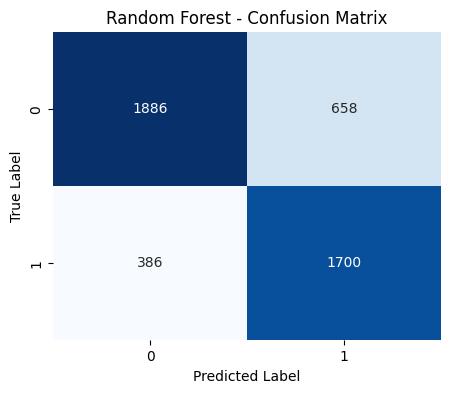

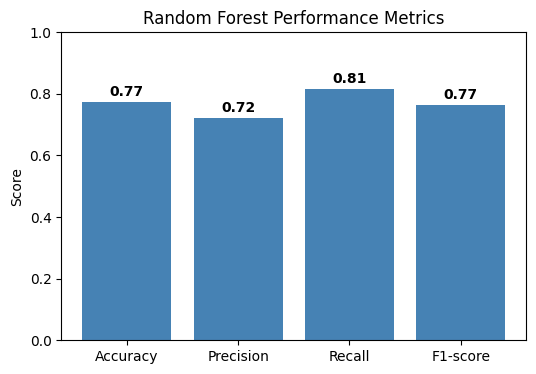

Cross-Validation Scores: [0.76655378 0.7731835  0.76775652 0.7754105  0.76624413]
Mean CV Score: 0.7698296832786283


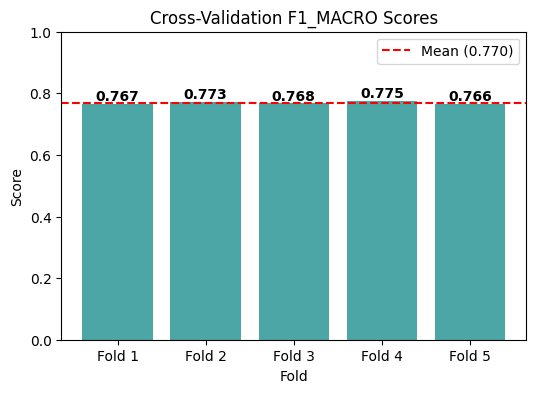

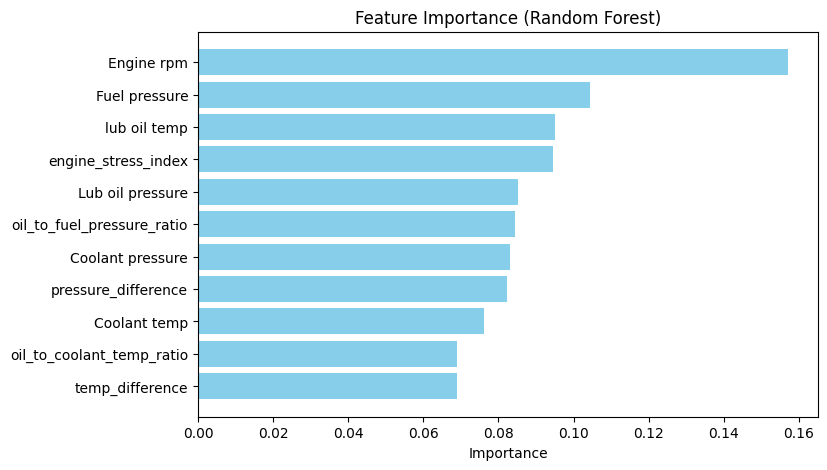

In [23]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

accuracy_rf =show_model_accuracy("Random Forest", y_pred, y_test)

cross_validation_setup(rf_clf)


importances = rf_clf.feature_importances_
sorted_idx = importances.argsort()

plt.figure(figsize=(8, 5))
plt.barh(range(len(importances)), importances[sorted_idx], color='skyblue')
plt.yticks(range(len(importances)), X.columns[sorted_idx])
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()


**Insights**: *Among the models, Random forest(RF) is the leading base model to show a promising result, that's why we will use RF on both base_model and meta_model for promising result.*
*With RF we are able to see the importance of each feature.*

#### ***Decision Tree Model***

Decision Tree Accuracy:  0.7306695464362851
              precision    recall  f1-score   support

           0       0.80      0.69      0.75      2629
           1       0.66      0.78      0.71      2001

    accuracy                           0.73      4630
   macro avg       0.73      0.74      0.73      4630
weighted avg       0.74      0.73      0.73      4630



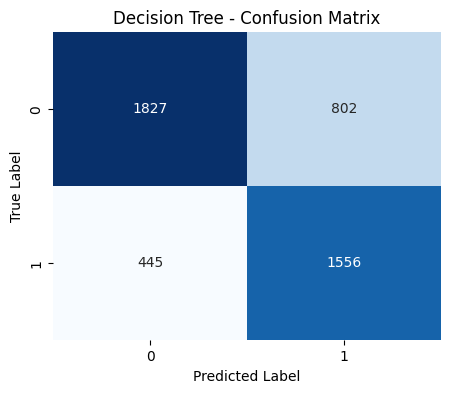

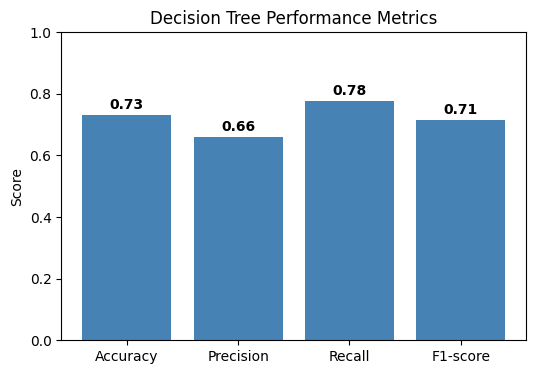

Cross-Validation Scores: [0.73110285 0.70876885 0.71879486 0.71889653 0.72271569]
Mean CV Score: 0.7200557551621198


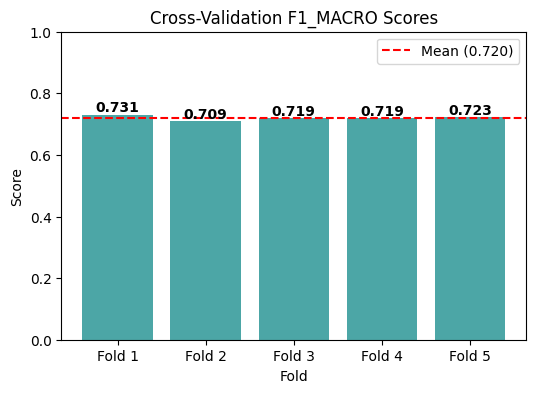

array([0.73110285, 0.70876885, 0.71879486, 0.71889653, 0.72271569])

In [24]:
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_model.fit(X_train, y_train)
y_pred = dtc_model.predict(X_test)

accuracy_dtc =show_model_accuracy("Decision Tree", y_pred, y_test)

# --- Cross Validation Setup ---
cross_validation_setup(dtc_model)

**Insights**: *Decision Tree(DTC) also shows a good score, emphasizing that  *

#### ***Gradient Boosting***

Gradient Boosting (GBC) Accuracy:  0.6786177105831533
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      2494
           1       0.64      0.70      0.67      2136

    accuracy                           0.68      4630
   macro avg       0.68      0.68      0.68      4630
weighted avg       0.68      0.68      0.68      4630



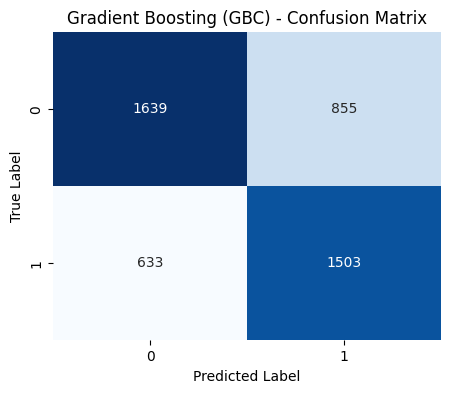

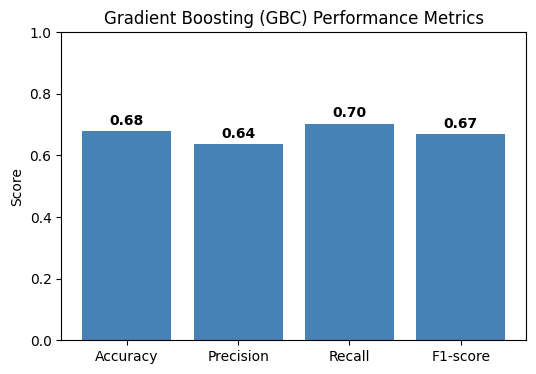

Cross-Validation Scores: [0.68155068 0.67229637 0.6694949  0.68459606 0.67738086]
Mean CV Score: 0.6770637768122583


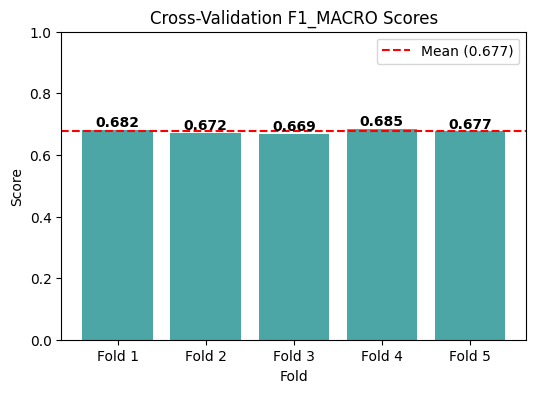

array([0.68155068, 0.67229637, 0.6694949 , 0.68459606, 0.67738086])

In [25]:
gbc = GradientBoostingClassifier(
    random_state=42,
    learning_rate=0.2, 
    max_depth=4, 
    min_samples_leaf= 1, 
    min_samples_split= 4, 
    n_estimators= 150, 
    subsample= 1.0
)

gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

accuracy_gbc = show_model_accuracy("Gradient Boosting (GBC)", y_pred, y_test)

cross_validation_setup(gbc)


**Insight**: *Although it only has 67% accuracy, compared to SVM and LR, it is a little bit better. Based on my trial and error of finding the best combination, this increases the accuracy*

#### ***XGBoost***

XGBoost Accuracy:  0.7494600431965442
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      2594
           1       0.69      0.79      0.74      2036

    accuracy                           0.75      4630
   macro avg       0.75      0.75      0.75      4630
weighted avg       0.76      0.75      0.75      4630



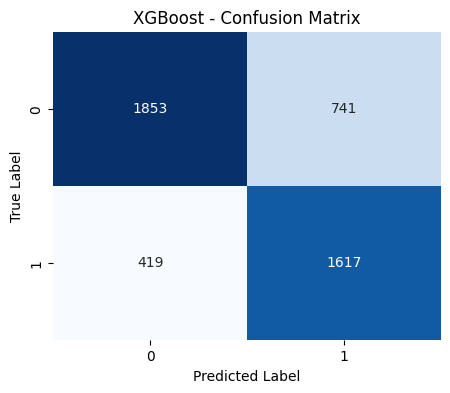

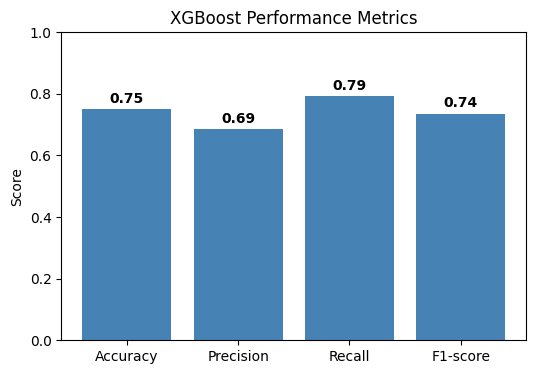

Cross-Validation Scores: [0.75383111 0.74039583 0.75283733 0.75866768 0.74953854]
Mean CV Score: 0.7510540967460901


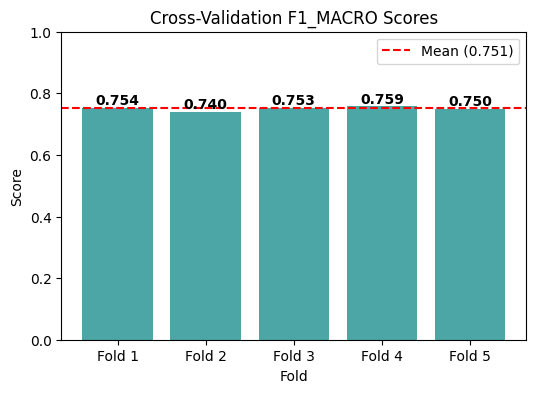

array([0.75383111, 0.74039583, 0.75283733, 0.75866768, 0.74953854])

In [26]:
xgb = XGBClassifier(
    random_state=42,
    colsample_bytree= 0.8, 
    gamma = 0, 
    learning_rate= 0.2,
    max_depth=7,
    min_child_weight= 1, 
    n_estimators= 300,
    subsample= 1.0
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy_xgb = show_model_accuracy("XGBoost", y_pred, y_test)

cross_validation_setup(xgb)


**Insights**: *This is the 2nd model that has the high score, so i am going to include this.*

#### ***Stacking Ensemble: RandomForest + KNN + XGBoost + Gradient Boosting***

Stacking Ensemble: RandomForest + KNN + XGBoost + Gradient Boosting Accuracy:  0.8200863930885529
              precision    recall  f1-score   support

           0       0.71      0.91      0.79      1767
           1       0.93      0.77      0.84      2863

    accuracy                           0.82      4630
   macro avg       0.82      0.84      0.82      4630
weighted avg       0.84      0.82      0.82      4630



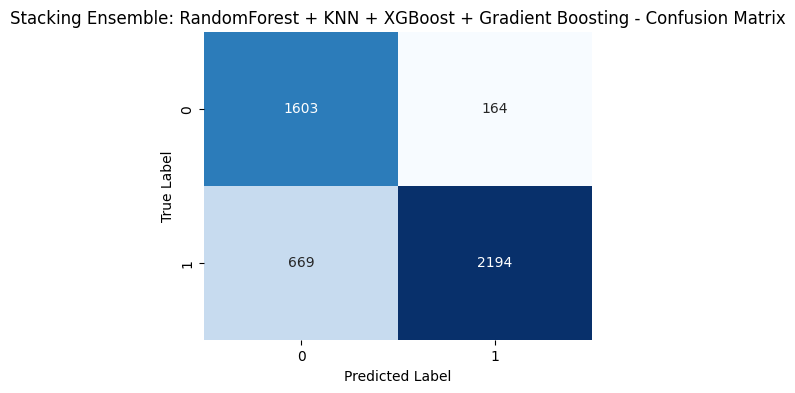

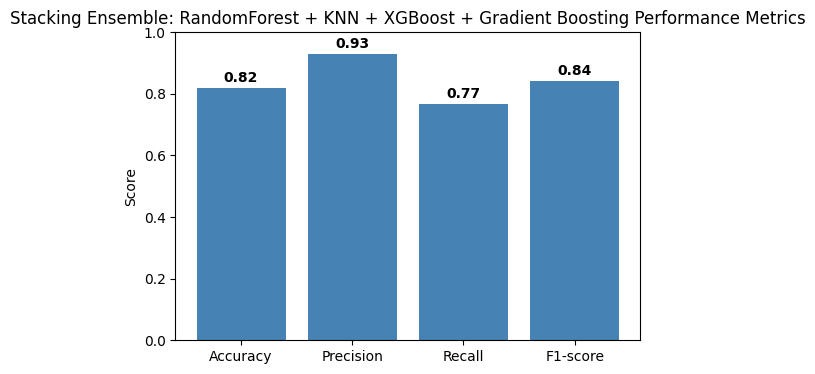

Cross-Validation Scores: [0.81834178 0.80649468 0.8103684  0.81033793 0.8152432 ]
Mean CV Score: 0.8121571964721461


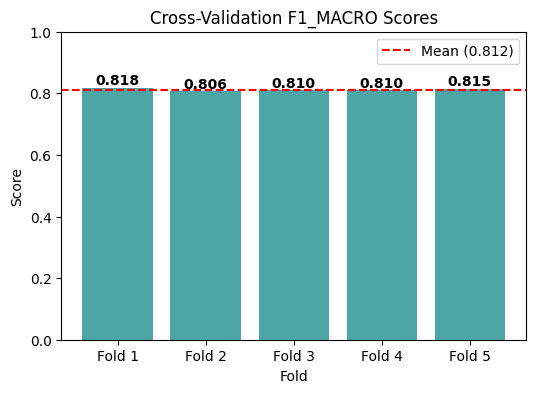

array([0.81834178, 0.80649468, 0.8103684 , 0.81033793, 0.8152432 ])

In [27]:
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=1, random_state=42)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=23, metric='euclidean', weights='distance'))),
    ('xgb', XGBClassifier(random_state=42, colsample_bytree= 0.8, gamma = 0, learning_rate= 0.1, max_depth=7, min_child_weight= 1, n_estimators= 300, subsample= 1.0)),
    ('gbc', GradientBoostingClassifier(random_state=42, learning_rate=0.15, max_depth=3, min_samples_leaf= 1, min_samples_split= 4, n_estimators= 200, subsample= 1.0))
]

meta_model = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=1, random_state=42)


stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=10,
    passthrough=True,
    n_jobs=-1,
)


model = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', stacking_clf)
])
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

accuracy_pipeline = show_model_accuracy("Stacking Ensemble: RandomForest + KNN + XGBoost + Gradient Boosting", y_pred, y_test)
# Cross-validation
cross_validation_setup(model)

**Insight**: *By combining RF, KNN, XGBoost, and Gradient Boosting, we are able to achieve 82% accuracy.* 

#### ***Model Performance Comparison***

                 Model  Accuracy
5    Combined Pipeline  0.820086
3        Random Forest  0.774514
6                  XGB  0.749460
4        Decision Tree  0.730670
1                  KNN  0.727646
7                  GBC  0.678618
2                  SVM  0.652916
0  Logistic Regression  0.640389


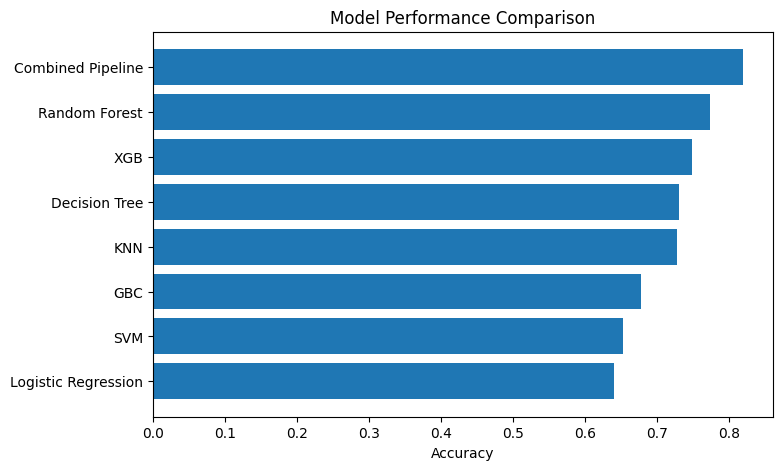

In [28]:

model_scores = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVM', 'Random Forest', 'Decision Tree', 'Combined Pipeline', "XGB", 'GBC'],
    'Accuracy': [accuracy_lr, accuracy_knn, accuracy_svm, accuracy_rf, accuracy_dtc, accuracy_pipeline, accuracy_xgb, accuracy_gbc]
})

model_scores = model_scores.sort_values(by='Accuracy', ascending=False)
print(model_scores)

plt.figure(figsize=(8, 5))
plt.barh(model_scores['Model'], model_scores['Accuracy'])
plt.xlabel('Accuracy')
plt.title('Model Performance Comparison')
plt.gca().invert_yaxis()  # highest at top
plt.show()

**Insights**: *The leading models is the Combined Pipeline or the ensemble so naturally that is the one we are going to use.*

In [33]:
# Synthetic test samples
test_records = pd.DataFrame([
    # Healthy
    [800, 3.25, 11.8, 2.9, 81.2, 79.8, 1.017, 1.4, 0.275, 8.9, 2885.4],
    [720, 2.95, 12.3, 2.6, 83.1, 81.6, 1.018, 1.5, 0.240, 9.7, 2950.7],
    [760, 3.40, 11.2, 3.1, 80.5, 79.0, 1.019, 1.5, 0.303, 8.1, 2798.2],
    # Unhealthy
    [1210, 4.05, 6.82, 2.30, 76.9, 75.9, 1.016, 0.95, 0.607, 1.68, 2060.2],
    [810, 3.69, 7.49, 1.25, 77.2, 84.3, 0.915, -7.95, 0.483, 2.30, 1692.1],
    [946, 3.84, 6.70, 4.27, 77.6, 79.4, 0.978, -1.77, 0.574, -0.429, 1648.2],

], columns=[
    "Engine rpm", "Lub oil pressure", "Fuel pressure", "Coolant pressure",
    "lub oil temp", "Coolant temp", "oil_to_coolant_temp_ratio",
    "temp_difference", "oil_to_fuel_pressure_ratio", "pressure_difference",
    "engine_stress_index"
])
sample_scaled = scaler.transform(test_records.values)
# Predict using trained model
predictions = stacking_clf.predict(sample_scaled)
print(predictions)

[1 1 1 1 1 0]


/home/darren/Projects/CCMACLRL_COM231_PROJECT/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
